# Include Latitude and Longitude in Post-processed WRF

The purpose of this notebook is to figure out the best way to include the latitude and longitude values originally present in the WRF output data (as geolocation grids) in the final re-stacked data.

## Existing structure

### Current "improved" file structure

Explore the current file structure created from the existing re-stacking pipeline. Make a new directory for saving some sample files to figure this out, and copy in a sample "improved"/"fixed" file, created when repairing the wind data:

In [146]:
import os
import shutil
from pathlib import Path


# base dir from chinook:
base_dir = Path("/import/SNAP/wrf_data/project_data/wrf_data")
scratch_dir = Path("/center1/DYNDOWN/kmredilla/wrf_data/scratch")
scratch_dir.mkdir(exist_ok=True)
latlon_dir = base_dir.joinpath("include_latlon")
latlon_dir.mkdir(exist_ok=True)
# this is a sample file that was created as a replacement for
#  hosted data with incorrectly rotated wind
sample_fp = base_dir.joinpath("wind-issue/hourly_fix/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2006.nc")
copy_fp = latlon_dir.joinpath("u10_ccsm_2006_original_copy.nc")
shutil.copy(sample_fp, copy_fp)

PosixPath('/import/SNAP/wrf_data/project_data/wrf_data/include_latlon/u10_ccsm_2006_original_copy.nc')

Open the copied file and view it:

In [5]:
import xarray as xr


with xr.open_dataset(copy_fp) as ds:
    print(ds)
    test_arr = ds["u10"].sel(time="2006-01-01T00:00:00").values

<xarray.Dataset>
Dimensions:  (time: 8760, yc: 262, xc: 262)
Coordinates:
  * xc       (xc) float64 -2.61e+06 -2.59e+06 -2.57e+06 ... 2.59e+06 2.61e+06
  * yc       (yc) float64 -1.824e+05 -2.024e+05 ... -5.382e+06 -5.402e+06
  * time     (time) datetime64[ns] 2006-01-01 ... 2006-12-31T23:00:00
Data variables:
    u10      (time, yc, xc) float32 ...
Attributes:
    creation_date:    Sat May 13 13:02:24 AKDT 2017
    NCL_Version:      6.3.0
    system:           Linux n9 2.6.32-642.11.1.el6.686g0000.x86_64 #1 SMP Tue...
    Conventions:      None
    grib_source:      WRFDS_d01.2006-01-01_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   2006-01-01 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...
    crs_wkt:          PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknow...
    restacked_by:     Scenarios Network for Alaska + Arctic Planning -- 2018
    SNAP_VERSION:     1.0


### Re-stacked data with lat/lon info

Copy in the original "re-stacked" file predecessor to the above copied data:

In [6]:
# this is the predecessor to that copied file
stacked_sample_fp = base_dir.joinpath("wind-issue/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc")
stacked_copy_fp = latlon_dir.joinpath("u10_ccsm_2006_stacked_original_copy.nc")

shutil.copy(stacked_sample_fp, stacked_copy_fp)

PosixPath('/import/SNAP/wrf_data/project_data/wrf_data/include_latlon/u10_ccsm_2006_stacked_original_copy.nc')

and view it's header info plus the lat / lon grids:

In [8]:
with xr.open_dataset(stacked_copy_fp) as stacked_ds:
    print(stacked_ds)
    lat_arr = stacked_ds["lat"].values
    lon_arr = stacked_ds["lon"].values
    test_stacked_arr = stacked_ds["U10"].sel(time="2006-01-01T00:00:00").values

print("\nLatitude grid:\n", lat_arr)
print("\nLongitude grid:\n", lon_arr)

<xarray.Dataset>
Dimensions:  (time: 8760, x: 262, y: 262)
Coordinates:
    lon      (x, y) float32 ...
    lat      (x, y) float32 ...
  * time     (time) datetime64[ns] 2006-01-01 ... 2006-12-31T23:00:00
Dimensions without coordinates: x, y
Data variables:
    U10      (time, x, y) float32 ...
Attributes:
    creation_date:    Sat May 13 13:02:24 AKDT 2017
    NCL_Version:      6.3.0
    system:           Linux n9 2.6.32-642.11.1.el6.686g0000.x86_64 #1 SMP Tue...
    Conventions:      None
    grib_source:      WRFDS_d01.2006-01-01_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   2006-01-01 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...

Latitude grid:
 [[37.233    37.29895  37.364525 ... 37.367493 37.301937 37.236   ]
 [37.369934 37.43616  37.50201  ... 37.504993 37.439156 37.372944]
 [37.506927 37.573433 37.639565 ... 37.642555 37.576443 37.509953]
 ...
 [65.55994  65.740295 65.92076  ... 65.928955 65.74848  

### Create desired structure

Currently, it is looking like combining the tasks done in the "improvement" step should be combined in with the "re-stacking" step. I believe this will make for more straightforward pipeline, and there is the additional benefit that storing of virtually duplicate data would no longer be needed.

So, use the above restacked file as a jumping off point for both including the desired "fixes" from the improved data, as well as including the desired projection info and retaining the lat / lon grids.

#### Invert the grids vertically

The grid is flipped vertically in the final step ("improvement") of the existing re-stacking pipeline, and this can be confirmed by comparing the latitude grid with the `yc` variable of the original copied file above. The `yc` values decrease with increasing row idnex, while the latitude values in the first column increase with increasing row index. This should also be evident by visualizing a slice of the data for each:

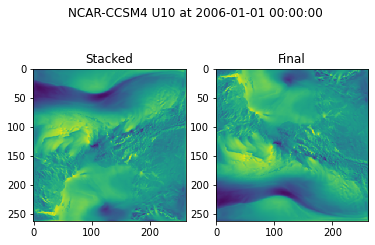

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("NCAR-CCSM4 U10 at 2006-01-01 00:00:00")
ax1.imshow(test_stacked_arr, interpolation="none")
ax1.set_title("Stacked")
ax2.imshow(test_arr, interpolation="none")
ax2.set_title("Final")
plt.show()

Flip the lat / lon and data arrays and store:

In [21]:
import numpy as np


# flip lat / lon arrays
lat_arr_flip = np.flipud(lat_arr)
lon_arr_flip = np.flipud(lon_arr)
# flip data arr along the Y axis, which will always be -2 regardless of variable being 3D or 4D
data_arr_flip = np.flip(stacked_ds["U10"].values, -2)

#### Get the projection information from geogrid file and derive coordinate system

The `wrf-python` packge includes classes to easily derive projection information (see the [tutorial notebook in the `snap-geo` repo](https://github.com/ua-snap/snap-geo/blob/3e0cfd813bd9d564b17e734991d9bc760d332624/project_wrf.ipynb) for more info). First load the geogrid file:

In [23]:
geo_ds = xr.open_dataset(base_dir.parent.joinpath("ancillary_wrf_constants/geo_em.d01.nc"))

Then use the `PolarStereographic` class to get the proj4 string for the WRF grid and derive the coordinate system:

In [175]:
from wrf import PolarStereographic
from pyproj import Proj, Transformer


wrf_vars = ["TRUELAT1", "TRUELAT2", "MOAD_CEN_LAT", "STAND_LON", "POLE_LAT", "POLE_LON"]
wrf_proj_str = PolarStereographic(**{var: geo_ds.attrs[var] for var in wrf_vars}).proj4()
# this "+nadgrids=@null" bit seems to be preventing the to_cf() methods from
#  creating the other projection attributes. When this is ommitted, the .to_cf()
#  method creates a set of attributes that allow correct projection in QGIS!
wrf_proj_str = wrf_proj_str.replace(" +nadgrids=@null", "")
wrf_proj = Proj(wrf_proj_str)
wgs_proj = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(wgs_proj, wrf_proj)

# Easting and Northings of the domains center point
e, n = transformer.transform(geo_ds.CEN_LON, geo_ds.CEN_LAT)
# Grid parameters
dx, dy = geo_ds.DX, geo_ds.DY
nx, ny = geo_ds.dims['west_east'], geo_ds.dims['south_north']
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# 2d grid
xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
x = xx[0,:]
# flip the y-axis to match flipped lat/lon grids and flipped data array
y = np.flip(yy[:,0])

print(f"Proj4 string for inclusion in file metadata: {wrf_proj_str}")

Proj4 string for inclusion in file metadata: +proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152.0 +lat_ts=64.0


Add the new x and y WRF projection coordinate values:

In [151]:
stacked_ds = stacked_ds.assign_coords({"y": y, "x": x})

Create a new CRS variable for storing the spatial info, and convert the `Proj` object to a `CRS` class and use the `CRS.to_cf()` method to add the spatial info to the new CRS variable:

In [176]:
crs_varname = "polar_stereographic"
# add grid mappting to variable attribute
stacked_ds["U10"].attrs["grid_mapping"] = crs_varname
# create CRS variable and add info
stacked_ds[crs_varname] = np.array(b"")
stacked_ds[crs_varname].attrs = wrf_proj.crs.to_cf()

Replace with flipped lon, lat, and data arrays:

In [137]:
stacked_ds["lon"] = (("y", "x"), lon_arr_flip)
stacked_ds["lat"] = (("y", "x"), lat_arr_flip)
stacked_ds["U10"] = (("time", "y", "x"), data_arr_flip)

Write to disk to check that the file opens in GIS software:

In [181]:
# subsetted to save space:
stacked_ds.sel(
    time=stacked_ds["time"].values[:2]
).to_netcdf(scratch_dir.joinpath("u10_ccsm_2006_stacked_with_latlon.nc"))

It opens and looks correct in QGIS. This should be all of the information needed to include with the re-stacking process so that the files retain their Lat/Lon arrays and have the correct spatial info to project automatically in popular GIS platforms.